## Summary: determine what category a paper belongs to based on its abstract

### Model Structure: I will be using a neural network with a pre-trained embedding layer (nnlm-en-dim50)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv/arxiv-metadata-oai-snapshot-2020-08-14.json


In [3]:
my_file = '../input/arxiv/arxiv-metadata-oai-snapshot-2020-08-14.json'

In [4]:
# get access to metadata
def get_metadata():
    with open(my_file, 'r') as f:
        for line in f:
            yield line
            
metadata = get_metadata()

In [5]:
import json
categories = []
abstract = []
for ind, paper in enumerate(metadata):
    paper = json.loads(paper)
    categories.append(paper['categories'])
    abstract.append(paper['abstract'])

In [6]:
# will only use the first category as a lable to simplify the problem
def clean_catagoris(catagorie):
    return catagorie.replace(' ','.').split('.')[0]


In [7]:
categories2 = []
for i in categories:
    categories2.append(clean_catagoris(i))

In [8]:
categories = pd.Series(categories2)


In [9]:
len(abstract)

1747307

In [10]:
# will only use 15% of the total data for training, to speed up training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    abstract, categories, test_size=0.85, random_state=42)

In [11]:
# turn y_train to catagories
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_num = le.transform(y_train)

In [12]:
len(np.unique(y_train))

38

In [13]:
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow as tf

# a neural network with pretrained embedding layer, the embedding layer also is trainable

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50],trainable=True),
    keras.layers.Dropout(rate=.4),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(rate=.4),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(rate=.4),
    keras.layers.Dense(38, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
history = model.fit(np.array(X_train),y_train_num, validation_split=.2, epochs=30,
                    callbacks=[early_stopping_cb])

Epoch 1/30
6553/6553 [==============================] - 118s 18ms/step - loss: 1.1078 - accuracy: 0.6771 - val_loss: 0.7470 - val_accuracy: 0.7690
Epoch 2/30
6553/6553 [==============================] - 117s 18ms/step - loss: 0.7851 - accuracy: 0.7655 - val_loss: 0.6887 - val_accuracy: 0.7870
Epoch 3/30
6553/6553 [==============================] - 116s 18ms/step - loss: 0.6974 - accuracy: 0.7897 - val_loss: 0.6800 - val_accuracy: 0.7916
Epoch 4/30
6553/6553 [==============================] - 115s 18ms/step - loss: 0.6467 - accuracy: 0.8038 - val_loss: 0.6833 - val_accuracy: 0.7913
Epoch 5/30
6553/6553 [==============================] - 115s 18ms/step - loss: 0.6094 - accuracy: 0.8154 - val_loss: 0.6973 - val_accuracy: 0.7923
Epoch 6/30
6553/6553 [==============================] - 115s 18ms/step - loss: 0.5814 - accuracy: 0.8228 - val_loss: 0.7111 - val_accuracy: 0.7897
Epoch 7/30
6553/6553 [==============================] - 116s 18ms/step - loss: 0.5621 - accuracy: 0.8285 - val_loss: 0

In [15]:
le.inverse_transform(model.predict_classes(X_test[:15]))

array(['math', 'astro-ph', 'nucl-th', 'gr-qc', 'math', 'quant-ph',
       'hep-ph', 'cs', 'astro-ph', 'cond-mat', 'astro-ph', 'hep-th',
       'gr-qc', 'stat', 'cond-mat'], dtype=object)

In [34]:
y_pred = le.transform(y_test[:5000])

In [36]:
model.evaluate(np.array(X_test[:5000]),y_pred)

AttributeError: 'list' object has no attribute 'values'

In [16]:
y_test[:15].values

array(['math', 'astro-ph', 'physics', 'astro-ph', 'math', 'quant-ph',
       'hep-ph', 'cs', 'astro-ph', 'cond-mat', 'astro-ph', 'hep-th',
       'gr-qc', 'math', 'physics'], dtype=object)

In [17]:
#an example of a wrong prediction
X_test[3]

'  We study cosmological perturbations in mimetic gravity in the presence of\nclassified higher derivative terms which can make the mimetic perturbations\nstable. We show that the quadratic higher derivative terms which are\nindependent of curvature and the cubic higher derivative terms which come from\ncurvature corrections are sufficient to remove instabilities in mimetic\nperturbations. The advantage of working with the classified higher derivative\nterms is that we can control both the background and the perturbation equations\nallowing us to construct the higher derivative extension of mimetic dark matter\nand the mimetic nonsingular bouncing scenarios. The latter can be thought as a\nnew higher derivative effective action for the loop quantum cosmology scenario\nin which the equations of motion coincide with those suggested by loop quantum\ncosmology. We investigate a possible connection between the mimetic cosmology\nand the Randall-Sundrum cosmology.\n'

In [18]:
from sklearn.metrics import confusion_matrix
pred = model.predict_classes(X_test[:5000])


In [30]:
cf_matrix = confusion_matrix(y_pred,pred)

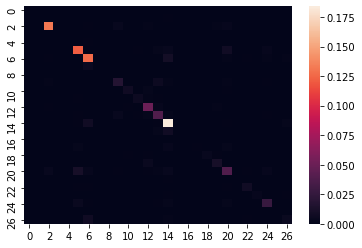

In [32]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix))

### Conclution: this model does well on a few cases but gets stuck on others, one way to potentially improve this model is to train an LSTM Model on it 